In [1]:
PROJECT_NAME = 'mobilenet_v3_dropout_test_eval'

# Import

In [2]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


In [3]:
import timm

In [4]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wand")

In [5]:
try:
    import wandb
except:
    !pip install wandb
    import wandb

wandb.login('allow',secret_value_0)
# wandb.login(secret_value_0)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from torch.utils.data import DataLoader

"""
Contains functions for training and testing a PyTorch model.
"""

from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [7]:
from dataset_helper import ImageFolderCustom
from model_engine import Engine
from helper_plot import plot_torch_hist

# Directory

In [8]:
data_path = Path('/kaggle/input/oral-dataset/patches')

In [9]:
image_dir = data_path / 'images'
train_df = pd.read_csv(data_path/'sabpatch_parsed_folders.csv')
train_ds = train_df[['path','lesion']]
test_df = pd.read_csv(data_path/'sabpatch_parsed_test.csv')
test_df = test_df[['path','lesion']]

In [10]:
test_size = 320

In [11]:
test_ds = test_df.iloc[:test_size]
eval_ds = test_df.iloc[test_size:]

# Global Parameters

In [12]:
ALPHA = 0.0006 ## Learning Rate
EPOCH = 50  ## Epochs
BATCH_SIZE = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DROPOUT = 0.5
PATIENCE = 10

# MEAN = [0.485, 0.456, 0.406]
# STD = [0.229, 0.224, 0.225]

In [13]:
model = timm.create_model(
    'mobilenetv3_large_100.ra_in1k',
    pretrained=True,
    num_classes=3,  # remove classifier nn.Linear
    drop_rate = DROPOUT
)

data_config = timm.data.resolve_model_data_config(model)
train_transforms = timm.data.create_transform(**data_config, 
                                        is_training=True,
                                                                
)
test_transforms = timm.data.create_transform(**data_config, 
                                             is_training=False)



model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

In [14]:
    train_data = ImageFolderCustom(targ_dir = image_dir,
                                          path_df = train_ds,
                                          transform= train_transforms)

    test_data = ImageFolderCustom(targ_dir = image_dir,
                                          path_df = test_ds,
                                          transform= test_transforms)
    
    eval_data = ImageFolderCustom(targ_dir = image_dir,
                                          path_df = eval_ds,
                                          transform= test_transforms)
    
    classes, class_to_idx = train_data.find_classes()

/kaggle/usr/lib/dataset-helper/dataset_helper.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.img_df['path'] = self.check_path(targ_dir)


In [15]:
classes

['OSCC', 'With dysplasia', 'Without dysplasia']

In [16]:
train_dataloader = DataLoader(dataset=train_data, # use custom created train Dataset
                                        batch_size=BATCH_SIZE, # how many samples per batch?
                                        num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                        shuffle=True, # shuffle the data?
                                        )

test_dataloader = DataLoader(dataset=test_data, # use custom created test Dataset
                                        batch_size=BATCH_SIZE,
                                        num_workers=0,
                                        shuffle=False) # don't usually need to shuffle testing data

eval_dataloader = DataLoader(dataset=eval_data, # use custom created test Dataset
                                        batch_size=BATCH_SIZE,
                                        num_workers=0,
                                        shuffle=False) # don't usually need to shuffle testing data


In [17]:
    wandb.init(
    project=PROJECT_NAME,
    config={
            "epochs": EPOCH,
            "batch_size": BATCH_SIZE,
            "lr": ALPHA,
            "architecture": "CNN",
            "dropout": DROPOUT,
            "patience":PATIENCE,
            "model":'mobilenetv3_large_100.ra_in1k',
            })


wandb: Currently logged in as: jhashulabh. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240218_103200-qgv1lboj
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run vermilion-peony-12
wandb: ⭐️ View project at https://wandb.ai/jhashulabh/mobilenet_v3_dropout_test_eval
wandb: 🚀 View run at https://wandb.ai/jhashulabh/mobilenet_v3_dropout_test_eval/runs/qgv1lboj


In [18]:
loss_fn = nn.CrossEntropyLoss(reduction='sum') # computes the cross entropy loss between input logits and target.

optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
Engine = Engine(model=model, loss_fn=loss_fn, optimizer=optimizer, device=device, early_stopping=True , config = wandb.config, dirpath = '/kaggle/working/model_weights')
result = Engine.train(train_dataloader=train_dataloader, test_dataloader=test_dataloader, epochs=EPOCH, verbose=True, patience=PATIENCE)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Epoch 1/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 1/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 1 | train_loss: 92.1652 | train_acc: 0.5395 | test_loss: 26.2168 | test_acc: 0.7219


Epoch 2/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 2/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 2 | train_loss: 54.6891 | train_acc: 0.5733 | test_loss: 30.4962 | test_acc: 0.6906
Early stopping counter: 1 out of 10


Epoch 3/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 3/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 3 | train_loss: 43.3515 | train_acc: 0.6122 | test_loss: 20.3705 | test_acc: 0.7750


Epoch 4/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 4/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 4 | train_loss: 36.0615 | train_acc: 0.6464 | test_loss: 27.3106 | test_acc: 0.6531
Early stopping counter: 1 out of 10


Epoch 5/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 5/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 5 | train_loss: 32.1849 | train_acc: 0.6559 | test_loss: 17.8448 | test_acc: 0.7719


Epoch 6/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 6/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 6 | train_loss: 32.0926 | train_acc: 0.6814 | test_loss: 16.4820 | test_acc: 0.7844


Epoch 7/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 7/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 7 | train_loss: 30.6729 | train_acc: 0.6789 | test_loss: 18.5330 | test_acc: 0.7719
Early stopping counter: 1 out of 10


Epoch 8/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 8/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 8 | train_loss: 28.0251 | train_acc: 0.6999 | test_loss: 17.1029 | test_acc: 0.7812
Early stopping counter: 2 out of 10


Epoch 9/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 9/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 9 | train_loss: 24.7199 | train_acc: 0.7188 | test_loss: 35.8574 | test_acc: 0.5969
Early stopping counter: 3 out of 10


Epoch 10/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 10/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 10 | train_loss: 25.7732 | train_acc: 0.7149 | test_loss: 14.3689 | test_acc: 0.8281


Epoch 11/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 11/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 11 | train_loss: 23.6644 | train_acc: 0.7277 | test_loss: 22.9580 | test_acc: 0.7375
Early stopping counter: 1 out of 10


Epoch 12/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 12/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 12 | train_loss: 25.2094 | train_acc: 0.7334 | test_loss: 20.2055 | test_acc: 0.7781
Early stopping counter: 2 out of 10


Epoch 13/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 13/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 13 | train_loss: 22.4877 | train_acc: 0.7401 | test_loss: 10.2245 | test_acc: 0.8781


Epoch 14/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 14/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 14 | train_loss: 21.6423 | train_acc: 0.7672 | test_loss: 12.5725 | test_acc: 0.8656
Early stopping counter: 1 out of 10


Epoch 15/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 15/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 15 | train_loss: 20.4946 | train_acc: 0.7663 | test_loss: 25.8186 | test_acc: 0.6969
Early stopping counter: 2 out of 10


Epoch 16/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 16/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 16 | train_loss: 20.3348 | train_acc: 0.7768 | test_loss: 13.1818 | test_acc: 0.8500
Early stopping counter: 3 out of 10


Epoch 17/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 17/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 17 | train_loss: 19.5971 | train_acc: 0.7899 | test_loss: 13.1515 | test_acc: 0.8469
Early stopping counter: 4 out of 10


Epoch 18/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 18/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 18 | train_loss: 18.2798 | train_acc: 0.7899 | test_loss: 15.3808 | test_acc: 0.8500
Early stopping counter: 5 out of 10


Epoch 19/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 19/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 19 | train_loss: 17.6478 | train_acc: 0.7991 | test_loss: 13.6026 | test_acc: 0.8187
Early stopping counter: 6 out of 10


Epoch 20/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 20/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 20 | train_loss: 17.0334 | train_acc: 0.8026 | test_loss: 16.4957 | test_acc: 0.8187
Early stopping counter: 7 out of 10


Epoch 21/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 21/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 21 | train_loss: 17.6851 | train_acc: 0.8080 | test_loss: 17.1550 | test_acc: 0.8313
Early stopping counter: 8 out of 10


Epoch 22/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 22/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 22 | train_loss: 16.9882 | train_acc: 0.8144 | test_loss: 20.3690 | test_acc: 0.7781
Early stopping counter: 9 out of 10


Epoch 23/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 23/50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch: 23 | train_loss: 15.9231 | train_acc: 0.8192 | test_loss: 13.0994 | test_acc: 0.8625
Early stopping counter: 10 out of 10
Early Stopping


wandb:                                                                                
wandb: W&B sync reduced upload amount by 95.2%             
wandb: 
wandb: Run history:
wandb:    test/test_acc ▄▃▅▂▅▆▅▆▁▇▅▆██▃▇▇▇▇▇▇▆█
wandb:   test/test_loss ▅▇▄▆▃▃▃▃█▂▄▄▁▂▅▂▂▂▂▃▃▄▂
wandb:      train/epoch ▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
wandb:  train/train_acc ▁▂▃▄▄▅▄▅▅▅▆▆▆▇▇▇▇▇▇████
wandb: train/train_loss █▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:    test/test_acc 0.8625
wandb:   test/test_loss 13.09936
wandb:      train/epoch 46.5
wandb:  train/train_acc 0.8192
wandb: train/train_loss 15.92306
wandb: 
wandb: 🚀 View run vermilion-peony-12 at: https://wandb.ai/jhashulabh/mobilenet_v3_dropout_test_eval/runs/qgv1lboj
wandb: Synced 6 W&B file(s), 23 media file(s), 7383 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240218_103200-qgv1lboj/logs


[INFO] Total training time: 1358.255 seconds


In [19]:
avg_loss, predictions = Engine.evaluate(eval_dataloader)
y_ts_true, y_ts_pred = predictions

  0%|          | 0/10 [00:00<?, ?batch/s]

In [20]:
result_df = pd.DataFrame(result)
# result_df.head()

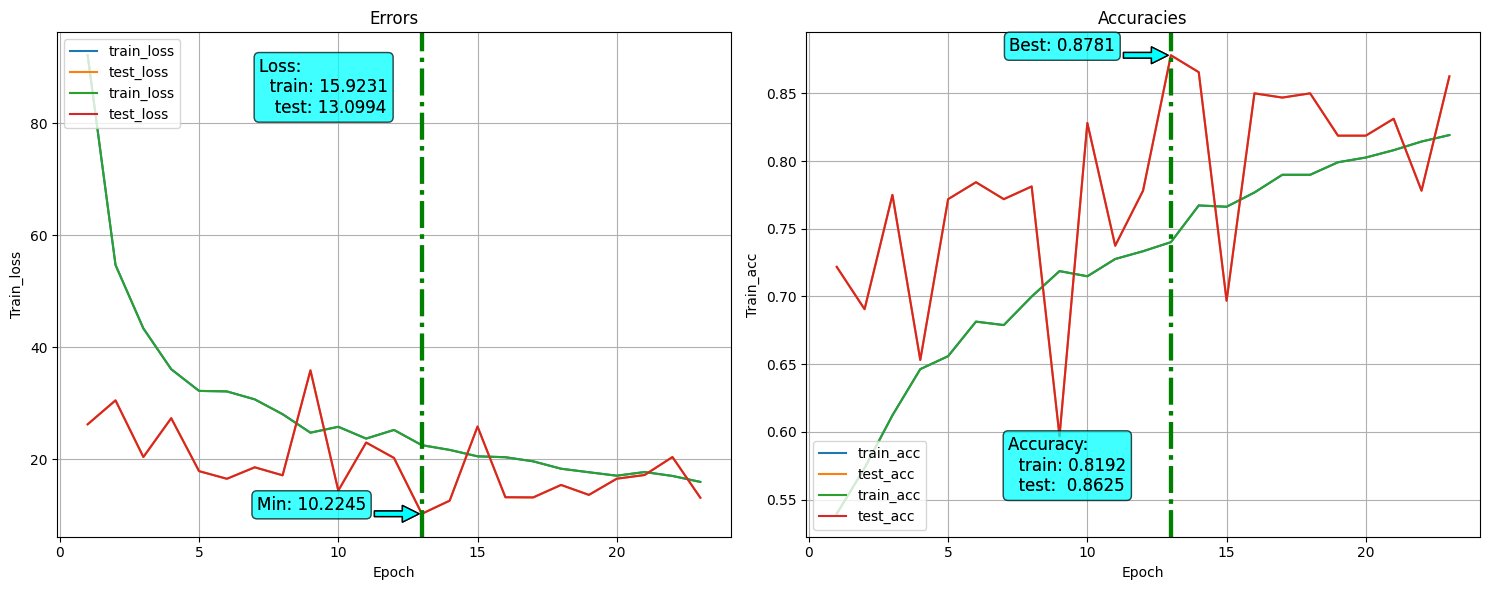

In [21]:
plot_torch_hist(result_df)

In [22]:
!pip install torchview
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(32,3,224,224))
model_arc = model_graph.visual_graph

In [23]:
!pip install graphviz
from graphviz import Digraph

# Create a Digraph object


# Render the graph to a file (e.g., PNG, PDF, etc.)
model_arc.render(filename='/kaggle/working/graph', format='png', cleanup=True)

'/kaggle/working/graph.png'

In [24]:
import matplotlib.pyplot as plt

In [25]:
accuracy = accuracy_score(y_ts_true, y_ts_pred) * 100
cf_matrix  = confusion_matrix(y_ts_true, y_ts_pred)  
f1_score = f1_score(y_ts_true, y_ts_pred, average='micro') 

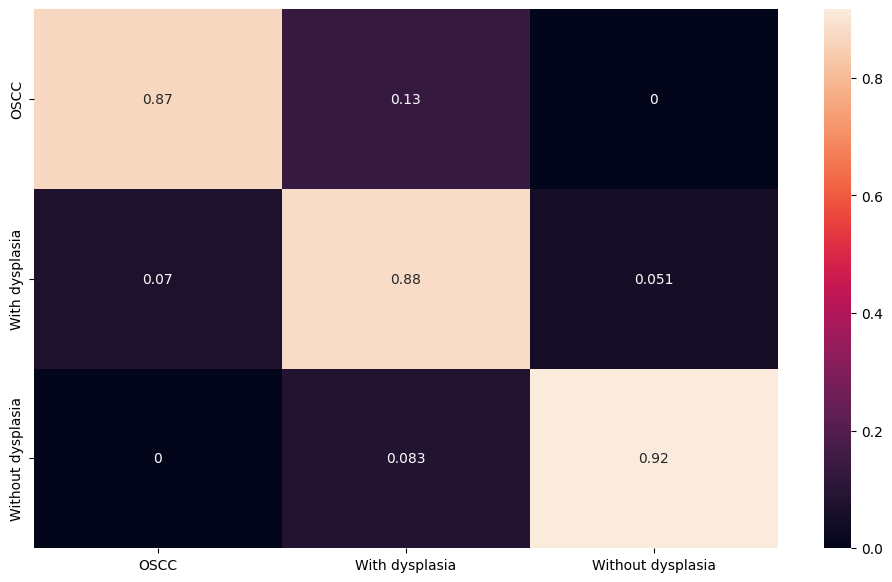

In [26]:
# constant for classes

# Build confusion matrix
# cf_matrix 
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.savefig('/kaggle/working/output.png')

In [27]:
accuracy

87.94788273615634

In [28]:
f1_score

0.8794788273615635